In [5]:
import importlib
import Custom_PINN_for_Poisson

importlib.reload(Custom_PINN_for_Poisson)

from Custom_PINN_for_Poisson import Sampler, PINN

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torch

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    #print('CUDA')
else:
    device = torch.device('cpu')
    #print('CPU')

### Solving the Poisson equation using PINN from the Deepxde library

In [7]:
def generate_poisson_problem(u_func, k = 3, m = 4):
    """Генерирует f(x, y) и g(x, y) для заданного аналитического решения u(x, y)"""
    def laplacian_u(xy):
        x, y = xy[:, 0:1], xy[:, 1:2]
        u_xx = -k**2 * torch.sin(k * x) * torch.cos(m * y)
        u_yy = -m**2 * torch.sin(k * x) * torch.cos(m * y)
        return -(u_xx + u_yy)
    
    
    f = laplacian_u
    g = lambda xy: u_func(xy[:, 0:1], xy[:, 1:2])
    return f, g

def create_deepxde_model(f, g, limits, num_domain=5000, num_boundary=1000):

    def poisson_residual(x, u):
        du_xx = dde.grad.hessian(u, x, i=0, j=0)
        du_yy = dde.grad.hessian(u, x, i=1, j=1)
        return du_xx + du_yy + f(x)
    
    def boundary(x, on_boundary):
        return on_boundary
    

    geom = dde.geometry.Rectangle(limits[0],limits[1])
    bc = dde.DirichletBC(geom, g, boundary)
    data = dde.data.PDE(geom, poisson_residual, bc, num_domain=num_domain, num_boundary=num_boundary)
    net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")
    
    model = dde.Model(data, net)
    model.compile("adam", lr=0.001)

    return model



def train_pinn(model, limits, N_it=10000, save_animation = False):
    
    if save_animation:
        # Создание сетки для визуализации
        X, Y = np.meshgrid(np.linspace(limits[0][0], limits[1][0], 100),
                        np.linspace(limits[0][1], limits[1][1], 100))
        points = np.vstack((X.flatten(), Y.flatten())).T

        images = []
        
        def save_plot(iteration):
            u_pred = model.predict(points).reshape(X.shape)

            plt.figure(figsize=(6,5))
            plt.contourf(X, Y, u_pred, levels=100, cmap="viridis")
            plt.colorbar(label="U(x, y)")
            plt.title(f"Iteration {iteration}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.savefig(f"frame_{iteration}.png")
            plt.close()

            images.append(f"frame_{iteration}.png")

        k = 500
        # Тренировка с сохранением изображений
        for i in range(0, N_it + 1, k):
            loss_history, train_state = model.train(iterations=k, display_every=1000)
            save_plot(i)

        # Создание GIF
        with imageio.get_writer("pinn_training.gif", mode="I", duration=0.5) as writer:
            for filename in images:
                image = imageio.imread(filename)
                writer.append_data(image)

    else:
        loss_history, train_state = model.train(iterations=N_it)
        
    dde.saveplot(loss_history, train_state, issave=True, isplot=True)
    
    return model, loss_history

In [8]:
limits = [[0, 0], [torch.pi, torch.pi]] # [x_min, y_min] , [x_max,y_max]

### Deepxde Experiments

##### Deepexe 1: sin(x)cos(y)

In [9]:
k = 1
m = 1
u_func = lambda x, y: torch.sin(torch.tensor(k * x)) * torch.cos(torch.tensor(m * y))
f, g = generate_poisson_problem(u_func, k, m)

model_1 = create_deepxde_model(f, g, limits=limits)

Compiling model...
'compile' took 1.036783 s



In [ ]:
model_1, loss_history_1 = train_pinn(model_1, f, g, limits)

In [15]:
torch.save(model_1.state_dict(), "Deepexde_model_1.pth")

In [10]:
model_1.net.load_state_dict(torch.load("Deepexde_model_1.pth"))

<All keys matched successfully>

##### Deepexe 2: sin(2x)cos(3y)

In [11]:
k = 2
m = 3
u_func = lambda x, y: torch.sin(torch.tensor(k * x)) * torch.cos(torch.tensor(m * y))
f, g = generate_poisson_problem(u_func, k, m)

model_2 = create_deepxde_model(f, g, limits=limits)

Compiling model...
'compile' took 0.000406 s



In [ ]:
model_2, loss_history_2 = train_pinn(model_2, f, g, limits)

In [17]:
torch.save(model_2.state_dict(), "Deepexde_model_2.pth")

In [12]:
model_2.net.load_state_dict(torch.load("Deepexde_model_2.pth"))

<All keys matched successfully>

##### Deepexe 3: sin(10x)cos(5y)

In [13]:
k = 10
m = 5
u_func = lambda x, y: torch.sin(torch.tensor(k * x)) * torch.cos(torch.tensor(m * y))
f, g = generate_poisson_problem(u_func, k, m)

model_3 = create_deepxde_model(f, g, limits=limits)

Compiling model...
'compile' took 0.000369 s



In [ ]:
model_3, loss_history_3 = train_pinn(model_3, f, g, limits)

In [19]:
torch.save(model_3.state_dict(), "Deepexde_model_3.pth")

In [14]:
model_3.net.load_state_dict(torch.load("Deepexde_model_3.pth"))

<All keys matched successfully>

In [ ]:
# Оценка качества
x_test = np.random.rand(1000, 2) * np.pi
y_exact = u_func(x_test[:, 0:1], x_test[:, 1:2])
y_pred = model_1.predict(x_test)
y_pred = torch.tensor(y_pred, device="cpu").numpy()

l2_abs_error = np.linalg.norm(y_pred - y_exact, 2)
l2_rel_error = l2_abs_error / np.linalg.norm(y_exact, 2)

print(f"Абсолютная L2 ошибка: {l2_abs_error}")
print(f"Относительная L2 ошибка: {l2_rel_error}")

NameError: name 'np' is not defined

### Solving the Poisson equation using Custom PINN

In [15]:
# Define the exact solution and its derivatives
def u(X, k = 1, m = 1):
    """
    :param x: x = (t, x)
    """
    x = X[:,0:1]
    y = X[:,1:2]
    return np.sin(k * x) * np.cos(m * y)

def u_x(X, k = 1, m = 1):
    x = X[:,0:1]
    y = X[:,1:2]
    u_x = k * np.cos(k * x) * np.cos(m * y)
    return u_x

def u_y(X, k = 1, m = 1):
    x = X[:,0:1]
    y = X[:,1:2]
    u_y = - m * np.sin(k * x) * np.sin(m * y)
    return u_y

def u_yy(X, k = 1, m = 1):
    x = X[:,0:1]
    y = X[:,1:2]
    u_yy = - m**2 * np.sin(k * x) * np.cos(m * y)
    return u_yy

def u_xx(X, k = 1, m = 1):
    x = X[:,0:1]
    y = X[:,1:2]
    u_xx = - k **2 * np.sin(k * x) * np.cos(m * y)
    return  u_xx

def r(x, k, m):
    return -(u_xx(x, k, m) + u_yy(x, k, m))

def operator(u, x, y):
    u_x = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u),
        retain_graph=True, create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x),
        retain_graph=True, create_graph=True
    )[0]

    u_y = torch.autograd.grad(
        u, y, grad_outputs=torch.ones_like(u),
        retain_graph=True, create_graph=True
    )[0]

    u_yy = torch.autograd.grad(
        u_y, y, grad_outputs=torch.ones_like(u_y),
        retain_graph=True, create_graph=True
    )[0]

    return -(u_xx + u_yy)

##### Custom 1: sin(10x)cos(y)

In [16]:
k = 1
m = 1

# Create boundary conditions samplers
bcs_sampler = Sampler(limits, lambda x: u(x,k,m), name='sample_boundary')

# Create residual sampler
res_sampler = Sampler(limits, lambda x: r(x,k,m), name='sample_interior')
# Define PINN model

layers = [2, 500, 1]
kernel_size = 300
model_custom_1 = PINN(layers, operator, bcs_sampler, res_sampler, learning_r=0.001)

In [22]:
model_custom_1.train(nIter=50000, batch_size=200, save_path="best_custom_1_1.pth")

It: 0, Loss: 1.521e+00, Loss_res: 1.124e+00,  Loss_bcs: 3.972e-01
It: 1000, Loss: 1.350e-02, Loss_res: 4.289e-03,  Loss_bcs: 9.212e-03
It: 2000, Loss: 7.556e-03, Loss_res: 4.234e-03,  Loss_bcs: 3.322e-03
It: 3000, Loss: 2.138e-03, Loss_res: 1.090e-03,  Loss_bcs: 1.049e-03
It: 4000, Loss: 2.014e-03, Loss_res: 1.110e-03,  Loss_bcs: 9.046e-04
It: 5000, Loss: 4.889e-03, Loss_res: 3.820e-03,  Loss_bcs: 1.069e-03
It: 6000, Loss: 2.385e-03, Loss_res: 1.381e-03,  Loss_bcs: 1.003e-03
It: 7000, Loss: 1.792e-03, Loss_res: 8.315e-04,  Loss_bcs: 9.606e-04
It: 8000, Loss: 2.476e-03, Loss_res: 1.766e-03,  Loss_bcs: 7.105e-04
It: 9000, Loss: 1.174e-03, Loss_res: 5.167e-04,  Loss_bcs: 6.575e-04
It: 10000, Loss: 3.983e-04, Loss_res: 1.661e-04,  Loss_bcs: 2.322e-04
It: 11000, Loss: 2.388e-04, Loss_res: 1.600e-04,  Loss_bcs: 7.881e-05
It: 12000, Loss: 1.571e-04, Loss_res: 9.749e-05,  Loss_bcs: 5.962e-05
It: 13000, Loss: 4.735e-04, Loss_res: 2.454e-04,  Loss_bcs: 2.281e-04
It: 14000, Loss: 3.007e-04, Loss_

In [17]:
model_custom_1.load_best_model("best_custom_1_1.pth")

##### Custom 2: sin(2x)cos(3y)

In [18]:
k = 2
m = 3

# Create boundary conditions samplers
bcs_sampler = Sampler(limits, lambda x: u(x,k,m), name='sample_boundary')

# Create residual sampler
res_sampler = Sampler(limits, lambda x: r(x,k,m), name='sample_interior')
# Define PINN model

layers = [2, 500, 1]
kernel_size = 300
model_custom_2 = PINN(layers, operator, bcs_sampler, res_sampler, learning_r=0.001)

In [24]:
model_custom_2.train(nIter=50000, batch_size=200, save_path="best_custom_2_3.pth")

It: 0, Loss: 4.061e+01, Loss_res: 4.035e+01,  Loss_bcs: 2.597e-01
It: 1000, Loss: 1.948e-01, Loss_res: 3.931e-02,  Loss_bcs: 1.555e-01
It: 2000, Loss: 1.341e-01, Loss_res: 5.930e-02,  Loss_bcs: 7.482e-02
It: 3000, Loss: 1.002e-01, Loss_res: 3.336e-02,  Loss_bcs: 6.687e-02
It: 4000, Loss: 8.319e-02, Loss_res: 3.867e-02,  Loss_bcs: 4.451e-02
It: 5000, Loss: 1.648e-01, Loss_res: 1.264e-01,  Loss_bcs: 3.834e-02
It: 6000, Loss: 1.003e-01, Loss_res: 3.732e-02,  Loss_bcs: 6.296e-02
It: 7000, Loss: 7.856e-02, Loss_res: 2.481e-02,  Loss_bcs: 5.375e-02
It: 8000, Loss: 1.618e-01, Loss_res: 1.219e-01,  Loss_bcs: 3.986e-02
It: 9000, Loss: 5.677e-02, Loss_res: 3.798e-02,  Loss_bcs: 1.879e-02
It: 10000, Loss: 5.637e-02, Loss_res: 3.623e-02,  Loss_bcs: 2.014e-02
It: 11000, Loss: 2.069e-01, Loss_res: 1.896e-01,  Loss_bcs: 1.722e-02
It: 12000, Loss: 7.367e-02, Loss_res: 4.443e-02,  Loss_bcs: 2.925e-02
It: 13000, Loss: 5.599e-02, Loss_res: 4.304e-02,  Loss_bcs: 1.295e-02
It: 14000, Loss: 7.750e-02, Loss_

In [19]:
model_custom_2.load_best_model("best_custom_2_3.pth")

##### Custom 3: sin(10x)cos(5y)

In [20]:
k = 10
m = 5

# Create boundary conditions samplers
bcs_sampler = Sampler(limits, lambda x: u(x,k,m), name='sample_boundary')

# Create residual sampler
res_sampler = Sampler(limits, lambda x: r(x,k,m), name='sample_interior')
# Define PINN model

layers = [2, 500, 1]
kernel_size = 300
model_custom_3 = PINN(layers, operator, bcs_sampler, res_sampler, learning_r=0.001)

In [26]:
model_custom_3.train(nIter=50000, batch_size=200, save_path="best_custom_5_10.pth")

It: 0, Loss: 4.776e+03, Loss_res: 4.776e+03,  Loss_bcs: 3.356e-01
It: 1000, Loss: 3.891e+03, Loss_res: 3.890e+03,  Loss_bcs: 3.359e-01
It: 2000, Loss: 4.055e+03, Loss_res: 4.055e+03,  Loss_bcs: 3.083e-01
It: 3000, Loss: 4.098e+03, Loss_res: 4.098e+03,  Loss_bcs: 3.622e-01
It: 4000, Loss: 3.877e+03, Loss_res: 3.877e+03,  Loss_bcs: 2.686e-01
It: 5000, Loss: 3.937e+03, Loss_res: 3.937e+03,  Loss_bcs: 2.369e-01
It: 6000, Loss: 4.123e+03, Loss_res: 4.122e+03,  Loss_bcs: 2.409e-01
It: 7000, Loss: 4.338e+03, Loss_res: 4.337e+03,  Loss_bcs: 3.231e-01
It: 8000, Loss: 3.281e+03, Loss_res: 3.281e+03,  Loss_bcs: 2.283e-01
It: 9000, Loss: 3.746e+03, Loss_res: 3.746e+03,  Loss_bcs: 2.742e-01
It: 10000, Loss: 3.929e+03, Loss_res: 3.929e+03,  Loss_bcs: 1.633e-01
It: 11000, Loss: 3.878e+03, Loss_res: 3.878e+03,  Loss_bcs: 1.707e-01
It: 12000, Loss: 2.352e+03, Loss_res: 2.351e+03,  Loss_bcs: 3.557e-01
It: 13000, Loss: 2.094e+03, Loss_res: 2.094e+03,  Loss_bcs: 3.646e-01
It: 14000, Loss: 1.962e+03, Loss_

In [21]:
model_custom_3.load_best_model("best_custom_5_10.pth")

### Solving the Poisson equation using FEniCS

#### FEniCS 1: sin(x)cos(y)

In [46]:
u1_fenics = np.load("FEniCS_1_1.npy")

#### FEniCS 2: sin(2x)cos(3y)

In [27]:
u2_fenics = np.load("FEniCS_2_3.npy")

#### FEniCS 3: sin(10x)cos(5y)

In [28]:
u3_fenics = np.load("FEniCS_10_5.npy")

## Comparison of different solutions

In [ ]:
X_partition = 100
Y_partition = 100
left = 0
right = np.pi

X = np.linspace(left,right,X_partition)
Y = np.linspace(left,right,Y_partition)
x, y = np.meshgrid(X, Y)
grid_points = np.vstack([x.ravel(), y.ravel()]).T 


z1 = np.sin(1 * x) * np.cos(1 * y)
# Deepxde
u1 = model_1.predict(grid_points)
u1 = u1.reshape(X_partition,Y_partition)
# Custom
u1_custom = model_custom_1.predict_u(grid_points).cpu().detach().numpy()
u1_custom = u1_custom.reshape(X_partition,Y_partition)
# FEniCS
u1_fenics = u1_fenics.reshape(X_partition,Y_partition)

dif1 = z1 - u1
dif1_custom = z1 - u1_custom
dif1_fenics = z1 - u1_fenics


z2 = np.sin(2*x) * np.cos(3*y)
# Deepxde
u2 = model_2.predict(grid_points)
u2 = u2.reshape(X_partition,Y_partition)
# Custom
u2_custom = model_custom_2.predict_u(grid_points).cpu().detach().numpy()
u2_custom = u2_custom.reshape(X_partition,Y_partition)
# FEniCS
u2_fenics = u2_fenics.reshape(X_partition,Y_partition)

dif2 = z2 - u2
dif2_custom = z2 - u2_custom
dif2_fenics = z2 - u2_fenics


z3 = np.sin(10*x) * np.cos(5*y)
# Deepxde
u3 = model_3.predict(grid_points)
u3 = u3.reshape(X_partition,Y_partition)
# Custom
u3_custom = model_custom_3.predict_u(grid_points).cpu().detach().numpy()
u3_custom = u3_custom.reshape(X_partition,Y_partition)
# FEniCS
u3_fenics = u3_fenics.reshape(X_partition,Y_partition)

dif3 = z3 - u3
dif3_custom = z3 - u3_custom
dif3_fenics = z3 - u3_fenics

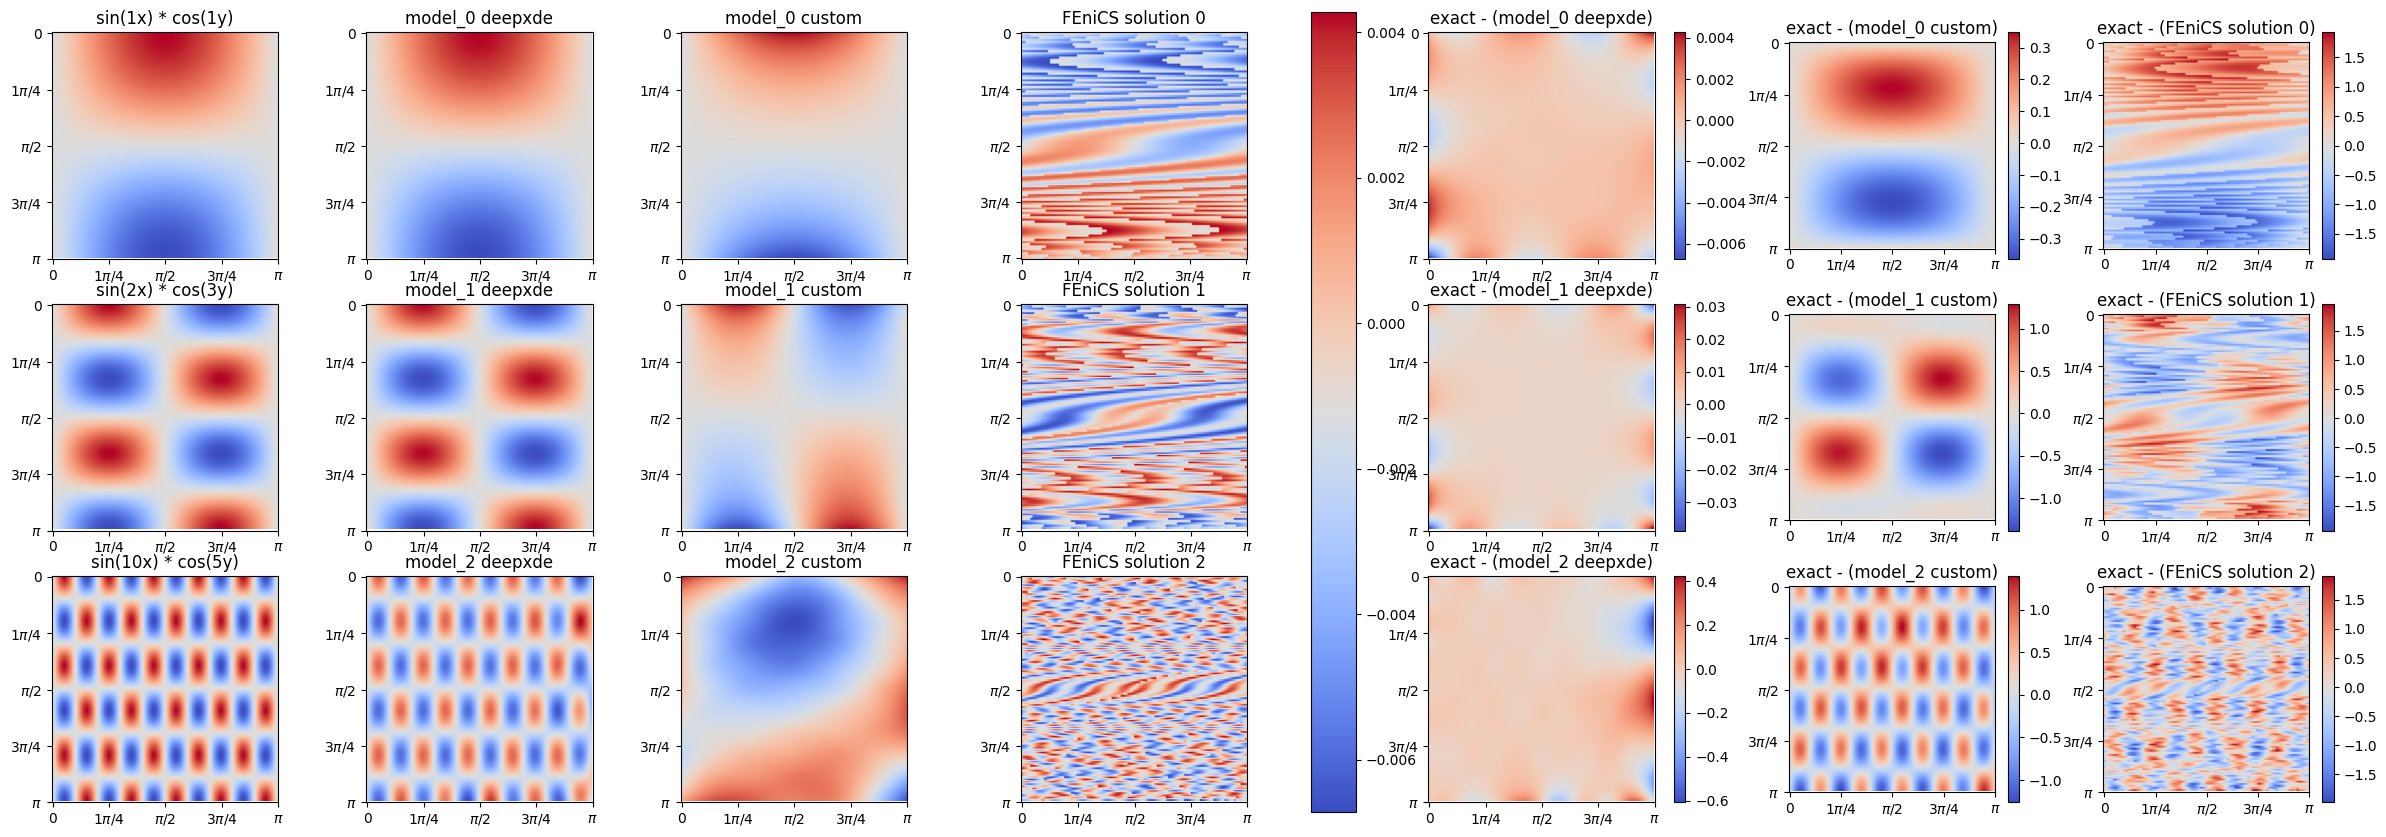

In [49]:
import matplotlib.pyplot as plt


data_list = [z1, u1, u1_custom, u1_fenics, dif1, dif1_custom, dif1_fenics,
             z2, u2, u2_custom, u2_fenics, dif2, dif2_custom, dif2_fenics,
             z3, u3, u3_custom, u3_fenics, dif3, dif3_custom, dif3_fenics]

ticks_X = np.linspace(0, X_partition, 5)
ticks_Y = np.linspace(0, Y_partition, 5)
tick_labels = ["0", r"$1 \pi/4$",r"$\pi/2$", r"$3 \pi/4$", r"$\pi$"]

fig, axes = plt.subplots(3, 7, figsize=(30, 10), gridspec_kw={'width_ratios': [1, 1, 1, 1.2, 1.5, 1, 1]})
for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap="coolwarm", vmin=data_list[i].min(), vmax=data_list[i].max())
    ax.set_title(f'{chr(97 + i)})')
    ax.set_xticks(ticks_X)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(ticks_Y)
    ax.set_yticklabels(tick_labels)
    if(i == 4):
        cbar_ax = fig.add_axes([0.55, 0.1, 0.015, 0.8])
        fig.colorbar(im, cax=cbar_ax)


    if(i % 7 > 7//2):
        fig.colorbar(im, ax=ax) # colorbar для правого столбца

pairs = [(1,1),(2,3),(10,5)]
for i in range(3):
    axes[i,0].set_title(f"sin({pairs[i][0]}x) * cos({pairs[i][1]}y)")
    axes[i,1].set_title(f"model_{i} deepxde")
    axes[i,2].set_title(f"model_{i} custom")
    axes[i,3].set_title(f"FEniCS solution {i}")

    axes[i,4].set_title(f"exact - (model_{i} deepxde)")
    axes[i,5].set_title(f"exact - (model_{i} custom)")
    axes[i,6].set_title(f"exact - (FEniCS solution {i})")

plt.show()